# 자동차 연비 예측하기: 회귀

## import

In [1]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load dataset

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/Users/user/.keras/datasets/auto-mpg.data'

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
dataset = dataset.dropna()

In [7]:
origin = dataset.pop("Origin")
len(origin)

392

In [8]:
# 범주형 데이터를 one-hot encoding으로 변환한다.
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### split train/test

In [9]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
len(train_dataset), len(test_dataset)

(314, 78)

### visualization

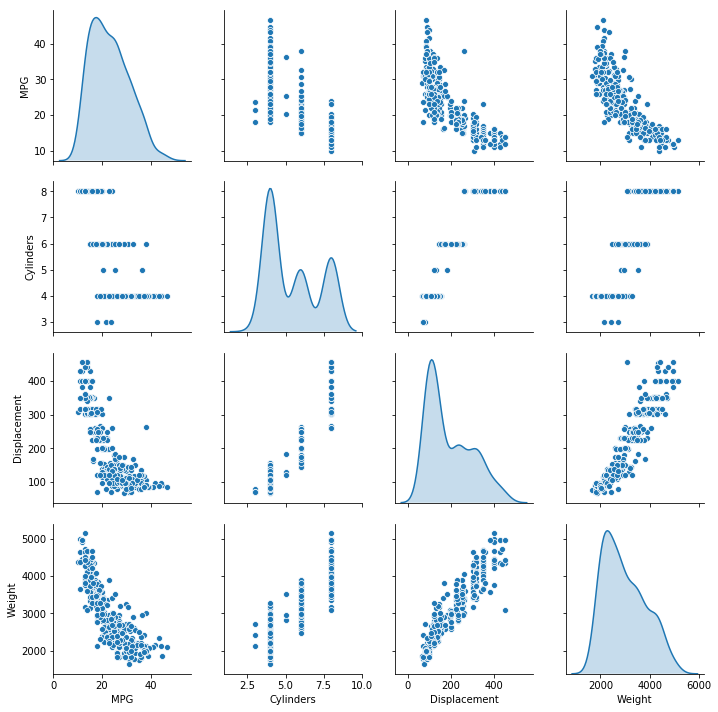

In [10]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### split labels

In [12]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### preprocessing

In [13]:
def norm(x):
    return (x - train_stats["mean"]) / train_stats["std"]

In [14]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [15]:
normed_train_data.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852


## Define model

In [19]:
model = keras.Sequential()
model.add(keras.layers.Dense(64, activation="relu", input_shape=[len(train_dataset.keys())]))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(0.001),
    loss="mse",
    metrics=["mae","mse"]
)

In [22]:
test_batch = normed_train_data[:10]
test_result = model.predict(test_batch)
test_result

array([[ 0.06730617],
       [-0.06921472],
       [ 0.16374665],
       [ 0.24812146],
       [ 0.10016224],
       [-0.18989806],
       [ 0.08764618],
       [ 0.42584813],
       [-0.12325125],
       [-0.04118509]], dtype=float32)

## Train model

In [24]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

In [25]:
history = model.fit(
    normed_train_data,
    train_labels,
    epochs=1000,
    validation_split=0.2,
    verbose=0,
    callbacks=[PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.900420,1.156005,2.900420,9.420061,2.265397,9.420061,995
996,2.811076,1.098729,2.811076,8.844264,2.189457,8.844263,996
997,2.634814,1.026491,2.634814,8.478458,2.185098,8.478457,997
998,2.703532,1.088767,2.703532,9.124820,2.260186,9.124820,998
999,2.666992,1.091791,2.666992,9.347518,2.341772,9.347519,999


## Visualize

In [30]:
import matplotlib.pyplot as plt

In [31]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

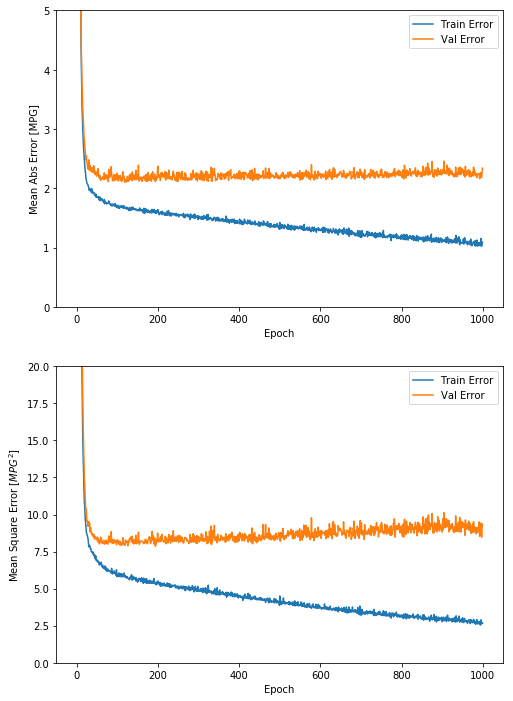

In [32]:
plot_history(history)

## Evaluate

In [33]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 7.0957 - mae: 2.0969 - mse: 7.0957
테스트 세트의 평균 절대 오차:  2.10 MPG


## Predict

In [35]:
test_predictions = model.predict(normed_test_data).flatten()
test_predictions

array([15.855837 ,  9.787465 , 11.758501 , 23.480793 , 20.675938 ,
       12.887334 , 12.64914  , 11.906549 , 19.297207 , 33.204643 ,
       20.521381 , 19.231178 , 16.039787 , 26.013468 , 12.657049 ,
       15.603801 , 14.254877 , 13.939669 , 18.584238 , 13.270825 ,
       13.667586 , 24.981949 , 18.159197 , 18.814775 , 27.362934 ,
       21.97626  , 16.726934 , 19.971245 , 17.937035 , 16.9275   ,
       24.157394 , 20.081865 , 19.273548 , 19.143263 , 24.662779 ,
       15.6976385, 18.949467 , 32.67826  , 28.005564 , 18.526985 ,
       29.246128 , 26.509037 , 15.510405 , 34.52599  , 36.03253  ,
       36.584282 , 19.8072   , 20.80483  , 20.54392  , 21.50421  ,
       30.969368 , 14.728005 , 32.225826 , 19.339504 , 18.151602 ,
       19.580875 , 33.578144 , 35.5876   , 23.392529 , 26.177193 ,
       38.374043 , 32.45077  , 25.879885 , 26.65281  , 30.837738 ,
       38.634705 , 36.160408 , 35.499886 , 36.06423  , 31.585161 ,
       23.005095 , 28.877602 , 29.43995  , 30.081427 , 38.1395

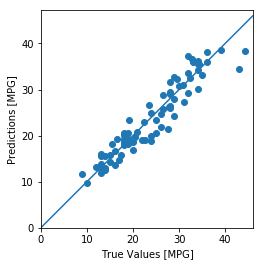

In [36]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

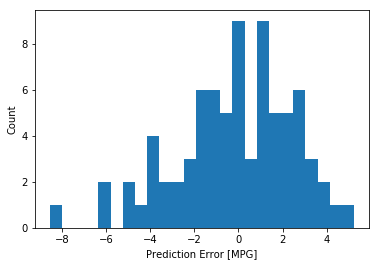

In [37]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")